# Quick Start: Submit a job to run on TPU VM in GKE using Vertex AI Pipelines

This quickstart notebook demonstrates how to create a job spec and submit to 
run on TPU VM in GKE using Vertex AI Pipeline.

## Before you begin

Before you run this notebook, ensure that you have set up the environment with prerequisites as described in the environment setup of the [README](README.md) file. 

## Install and import required packages

In [ ]:
# Install required packages
! pip -q install --upgrade google-cloud-aiplatform google-auth
! pip -q install protobuf==3.19.* 
! pip -q install kfp==1.8.16

In [ ]:
# Reloads modules automatically before executing any code/script
%load_ext autoreload
%autoreload 2

In [ ]:
! python3 -c "import kfp; print('KFP version: {}'.format(kfp.__version__))"
! python3 -c "import google.cloud.aiplatform as aip; print('Google AI Platform version: {}'.format(aip.__version__))"

In [ ]:
import os
from datetime import datetime
from google.cloud import aiplatform as vertex_ai
from kfp.v2 import compiler

In [ ]:
def get_timestamp():
    """return formatted date/time"""
    return datetime.now().strftime("%Y%m%d%H%M%S")

## Configure Environment Settings

Change the values of the following parameters to reflect your environment.

- `PROJECT_ID`: Project ID of your environment
- `ZONE`: Google Cloud Zone where your resources such as GKE cluster, TPU VM will be deployed and are located.
- `BUCKET_NAME`: Cloud Storage bucket to use for Vertex AI staging. Must be in the same region as ZONE.

<div class="alert alert-block alert-info"> 
⚠️ Please choose the region/zone based on the Cloud TPU availability. You can 
create TPU v2 or v3 configurations in the zones as shown <a href="https://cloud.google.com/tpu/docs/regions-zones">here</a>.
    
⚠️ Please make sure GKE cluster is created in the same zone as Cloud TPU VM.
</div>

In [ ]:
PROJECT_ID = '[your-project-id]'  # Change to your project ID
ZONE = 'us-central1-b'   # Change to your zone (example: us-central1-b)
BUCKET_NAME = '[your-bucket-name]'  # Change to your bucket name

In [ ]:
REGION = '-'.join(ZONE.split(sep='-')[:-1])
BUCKET_URI = f"gs://{BUCKET_NAME}"

<div class="alert alert-block alert-info"> 
⚠️ If you have set up the environment using the setup script <a href=./env-setup/install.sh><tt>install.sh</tt></a>
you DO NOT need to change the following settings. Otherwise make sure that they are consistent with your environment.
</div>

- `DOCKER_ARTIFACT_REPO`: Docker repository in Artifact Registry
- `IMAGE_NAME`: Base image name with dependencies to run a job on TPU VM in GKE

In [ ]:
# =============================================================================
# DO NOT UPDATE following unless you modified them in the install.sh
# =============================================================================
DOCKER_ARTIFACT_REPO = "tpu-vm-on-gke" # Docker repo in Artifact Registry
IMAGE_NAME = "tpu-vm-on-gke-base" # base container image name
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{IMAGE_NAME}"
os.environ['TPU_IN_GKE_IMAGE'] = IMAGE_URI

Define following parameters required for running the pipeline:

- `GKE_CLUSTER_NAME`: GKE cluster name you created during the [environment setup](README.md).
- `GKE_TPU_POOL_NAME`: GKE node pool name where TPU VM will be registered. Default: `tpu-pool`.
- `TPU_NAME`: Name of the TPU VM to create.
- `TPU_TYPE`: Specify a valid [TPU configuration](https://cloud.google.com/tpu/docs/supported-tpu-versions#tpu_v2_and_v3_configurations). E.g. `v2-8`, `v3-8`, `v2-32` etc.
- `TPU_RUNTIME_VERSION`: Version of [TPU software](https://cloud.google.com/tpu/docs/supported-tpu-versions#tpu_software_versions) depending on the framework (TensorFlow, PyTorch or JAX). E.g. `tpu-vm-base`

In [ ]:
GKE_CLUSTER_NAME = '[your-gke-cluster]' # Change to GKE cluster created during env setup
GKE_TPU_POOL_NAME = "tpu-pool" # Change to GKE node pool name where TPU VM will be registered
TPU_NAME = "[tpu-vm-name]" # Change to name of TPU VM you want to create
TPU_TYPE = "v2-8" # Change to TPU configuration you want to use
TPU_RUNTIME_VERSION = "tpu-vm-base" # Change to TPU software version you want to use

## Define Job Specification

This section shows how to define a job specification (YAML file) to run on TPU VM 
through GKE. The notebook has examples how to use TPU VM on both TPU device and Pod slices:

<table>
    <tr> 
        <th>Framework</th>
        <th>Job spec for TPU Device</th>
        <th>Job spec for TPU Pod</th>
    </tr>
    <tr> 
        <td>TensorFlow</td>
        <td><a href="#TensorFlow-Training-spec-on-a-TPU-device">TPU Device</a></td>
        <td><a href="#TensorFlow-Training-spec-on-a-TPU-Pod">TPU Pod</a></td>
    </tr>
    <tr> 
        <td>PyTorch</td>
        <td><a href="#PyTorch-Training-spec-on-a-TPU-device">TPU Device</a></td>
        <td><a href="#PyTorch-Training-spec-on-a-TPU-Pod">TPU Pod</a></td>
    </tr>
    <tr> 
        <td>JAX</td>
        <td><a href="#JAX-spec-on-a-TPU-device">TPU Device</a></td>
        <td><a href="#JAX-spec-on-a-TPU-Pod">TPU Pod</a></td>
    </tr>
</table>

### TensorFlow

#### TensorFlow Training spec on a TPU device

To use TensorFlow on a TPU device, you will need to do two setup steps:

- Install a TPU VM build of TensorFlow from `gs://cloud-tpu-tpuvm-artifacts/tensorflow/`
- Install `libtpu` from pip and create a symlink to `/lib/libtpu.so`

An example workload spec is shown below.

In [ ]:
EXPERIMENT_ID = 'tpu-device-tensorflow'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-training-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}

apiVersion: v1
kind: Pod
metadata:
  generateName: tpu-tensorflow-demo-
spec:
  affinity:
    nodeAffinity:
      requiredDuringSchedulingIgnoredDuringExecution:
        nodeSelectorTerms:
        - matchExpressions:
          - key: tpu.googleapis.com/name
            operator: In
            values:
            # this should reflect your TPU name
            - $TPU_NAME
          - key: tpu.googleapis.com/type
            operator: In
            values:
            - v2-8
            - v3-8
  restartPolicy: Never
  containers:
  - name: tpu-demo
    securityContext:
      privileged: true
    image: python:3.8
    command:
    - bash
    - -xc
    - |
      pip install https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/tensorflow/tf-2.8.0/tensorflow-2.8.0-cp38-cp38-linux_x86_64.whl
      curl -L https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/libtpu/1.2.0/libtpu.so -o /lib/libtpu.so

      curl -fsSL https://github.com/tensorflow/models/archive/refs/heads/r2.8.0.tar.gz | tar xz
      cd models-r2.8.0/
      pip install -r official/requirements.txt
      PYTHONPATH=\$(pwd) python official/vision/image_classification/mnist_main.py --tpu=local --distribution_strategy=tpu
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

#### TensorFlow Training spec on a TPU Pod

Running TPU VM workloads on pods is similar to running workloads on TPU Nodes, since both run the workload over GRPC. Thus, you don't need to install the TPU VM build of TensorFlow or `libtpu` on the main container. However, you will have to start the TPU GRPC runtime in your workload spec.

<div class="alert alert-block alert-info">
        <b>⚠️</b> 
        Caveats:
    <ul> 
        <li>Before starting the TPU runtime through GKE, you must stop the dummy runtime on each TPU worker. Example: <br/>
            <pre>gcloud compute config-ssh
gcloud compute tpus tpu-vm ssh $TPU_NAME \
  --project=$PROJECT_ID \
  --zone=$ZONE \
  --worker=all \
  --command "sudo systemctl stop tpu-runtime
</pre>
        </li>
        <li>Any input data must be accessible from the tpu-runtime container (e.g. in Cloud Storage or mounted in that container).</li>
        <li>Because the tpu-runtime container will not stop on its own, you must manually delete the Job when it is finished.</li>
    </ul>
</div>

An example TensorFlow workload spec to run on TPU v2-32 is shown below:

In [ ]:
EXPERIMENT_ID = 'tpu-pod-tensorflow'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-training-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
! gcloud alpha compute tpus tpu-vm ssh gke-tpu-vm --project=$PROJECT_ID --zone=$ZONE --worker=all --command "sudo systemctl stop tpu-runtime"

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}

apiVersion: batch/v1
kind: Job
metadata:
  generateName: tpu-tensorflow-pod-demo-
spec:
  backoffLimit: 0
  completions: 4
  parallelism: 4
  template:
    spec:
      hostNetwork: true
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: tpu.googleapis.com/name
                operator: In
                values:
                # this should reflect your TPU name
                - $TPU_NAME
              - key: tpu.googleapis.com/type
                operator: In
                values:
                - v2-32
      restartPolicy: Never
      containers:
      - name: tpu-runtime
        securityContext:
          privileged: true
        image: gcr.io/cloud-tpu-v2-images/grpc_tpu_worker:tf-2.7.0
        resources:
          requests:
            # Lower to 40 for v3 TPU pods.
            cpu: 90
      - name: tpu-demo
        image: python:3.8
        command:
        - bash
        - -c
        - |
          # Only run the workload on worker 0
          WORKER_ID=\$(curl -s 'http://metadata.google.internal/computeMetadata/v1/instance/attributes/agent-worker-number' -H 'Metadata-Flavor: Google')
          if [[ "\$WORKER_ID" != 0 ]]; then
            exit 0
          fi

          # Get the TPU VM's name from metadata
          export TPU_NAME=\$(basename \$(curl -s 'http://metadata.google.internal/computeMetadata/v1/instance/attributes/agent-node-name' -H 'Metadata-Flavor: Google'))
          pip install tensorflow cloud-tpu-client

          # Do some basic math on each core
          python -c "
          import os
          import tensorflow as tf
          cr = tf.distribute.cluster_resolver.TPUClusterResolver(os.getenv('TPU_NAME'))
          tf.config.experimental_connect_to_cluster(cr)
          tf.tpu.experimental.initialize_tpu_system(cr)
          strategy = tf.distribute.TPUStrategy(cr)

          @tf.function
          def add_fn(x,y):
              z = x + y
              return z

          x = tf.constant(1.)
          y = tf.constant(1.)
          z = strategy.run(add_fn, args=(x,y))
          print(z)
          "
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

### PyTorch

#### PyTorch Training spec on a TPU device

To use PyTorch on a TPU device, you will need to do two setup steps:

- Increase the size of `/dev/shm/`
- Install `libtpu_nightly` with `pip`.


An example workload spec is shown below.

In [ ]:
EXPERIMENT_ID = 'tpu-device-pytorch'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-training-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}

apiVersion: v1
kind: Pod
metadata:
  generateName: tpu-pytorch-demo-
spec:
  affinity:
    nodeAffinity:
      requiredDuringSchedulingIgnoredDuringExecution:
        nodeSelectorTerms:
        - matchExpressions:
          - key: tpu.googleapis.com/name
            operator: In
            values:
            # this should reflect your TPU name
            - $TPU_NAME
          - key: tpu.googleapis.com/type
            operator: In
            values:
            - v2-8
            - v3-8
  restartPolicy: Never
  volumes:
  # Increase size of tmpfs /dev/shm to avoid OOM.
  - name: dshm
    emptyDir:
      medium: Memory
  containers:
  - name: tpu-demo
    securityContext:
      privileged: true
    image: gcr.io/tpu-pytorch/xla:r1.10_3.8_tpuvm
    command:
    - bash
    - -c
    - |
      pip install https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/wheels/libtpu-nightly/libtpu_nightly-0.1.dev20211015-py3-none-any.whl
      python /pytorch/xla/test/test_train_mp_mnist.py
    volumeMounts:
    - mountPath: /dev/shm
      name: dshm
    env:
    - name: XRT_TPU_CONFIG
      value: localservice;0;localhost:51011
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

#### PyTorch Training spec on a TPU Pod

Using PyTorch XLA on pods requires some extensive environment variable setup. Copy the example below and substitute your own command. You will also need to update `XRT_SHARD_WORLD_SIZE` and `TPU_HOST_BOUNDS` according to your TPU pod size (see comments below for more details).

An example PyTorch workload spec to run on TPU v2-32 is shown below:

In [ ]:
EXPERIMENT_ID = 'tpu-pod-pytorch'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-training-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}
apiVersion: batch/v1
kind: Job
metadata:
  generateName: tpu-pytorch-pod-demo-
spec:
  backoffLimit: 0
  completions: 4
  parallelism: 4
  template:
    spec:
      hostNetwork: true
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: tpu.googleapis.com/name
                operator: In
                values:
                # this should reflect your TPU name
                - $TPU_NAME
              - key: tpu.googleapis.com/type
                operator: In
                values:
                - v2-32
      restartPolicy: Never
      volumes:
      # Increase size of tmpfs /dev/shm to avoid OOM.
      - name: dshm
        emptyDir:
          medium: Memory
      containers:
      - name: tpu-demo
        securityContext:
          privileged: true
        image: gcr.io/tpu-pytorch/xla:r1.10_3.8_tpuvm
        command:
        - bash
        - -xc
        - |
          pip install https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/wheels/libtpu-nightly/libtpu_nightly-0.1.dev20211015-py3-none-any.whl

          worker_id=\$(curl -s 'http://metadata.google.internal/computeMetadata/v1/instance/attributes/agent-worker-number' -H 'Metadata-Flavor: Google')
          project=\$(curl -sS "http://metadata.google.internal/computeMetadata/v1/project/project-id" -H "Metadata-Flavor: Google")
          zone=\$(basename \$(curl -sS "http://metadata.google.internal/computeMetadata/v1/instance/zone" -H "Metadata-Flavor: Google"))
          tpu_name=\$(curl -s 'http://metadata.google.internal/computeMetadata/v1/instance/attributes/instance-id' -H 'Metadata-Flavor: Google')
          worker_ips=(\$(gcloud compute tpus describe \${tpu_name} --project=\${project} --zone=\${zone} --flatten="networkEndpoints[]" --format="csv[no-heading](networkEndpoints.ipAddress)"))
          worker_0_ip="\${worker_ips[0]}"

          export XRT_LOCAL_WORKER="c_localservice:\${worker_id}"
          export XRT_SHARD_ORDINAL="\${worker_id}"
          export CLOUD_TPU_TASK_ID="\${worker_id}"
          export XRT_MESH_SERVICE_ADDRESS=\${worker_ips[0]}:8477
          export TPU_MESH_CONTROLLER_ADDRESS=\${worker_ips[0]}:8476
          if [ \$worker_id = 0 ]; then
            for ip in \${worker_ips[@]}; do
              tpu_configs+=("c_localservice;\$((idx++));\$ip:51011")
            done
            export XRT_TPU_CONFIG=\$(IFS="|"; echo "\${tpu_configs[*]}")
          fi

          python3 -m torch_xla.core.xrt_run_server --port 51011
          # Replace this with your model command
          python3 /pytorch/xla/test/test_train_mp_imagenet.py --fake_data --model=resnet50 --num_epochs=1
        volumeMounts:
        - mountPath: /dev/shm
          name: dshm
        env:
        # Update to number of cores divided by 8. (e.g. v3-32 -> 32 / 8 = 4)
        - name: XRT_SHARD_WORLD_SIZE
          value: '4'
        # Get bounds from PyTorch XLA code:
        # https://github.com/pytorch/xla/blob/09fc189db4efe3bd8e32c2791423a7793fa69ddc/torch_xla/distributed/xla_dist.py#L303
        - name: TPU_HOST_BOUNDS
          value: 2,2,1
        - name: TPU_CHIPS_PER_HOST_BOUNDS
          value: 2,2,1
        - name: TPU_NUM_DEVICES
          value: '8'
        - name: XLA_EMIT_STEPLOG
          value: '1'
        - name: TPUVM_MODE
          value: '1'
        - name: TPU_MESH_CONTROLLER_PORT
          value: '8476'
        resources:
          requests:
            # Lower to 40 for v3 TPU pods.
            cpu: 90
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

### JAX

#### JAX spec on a TPU device

You can simply `pip install jax[tpu]` to use JAX within the container to use the TPU.

Example TPU device workload:

In [ ]:
EXPERIMENT_ID = 'tpu-device-jax'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}

apiVersion: v1
kind: Pod
metadata:
  generateName: tpu-jax-demo-
spec:
  affinity:
    nodeAffinity:
      requiredDuringSchedulingIgnoredDuringExecution:
        nodeSelectorTerms:
        - matchExpressions:
          - key: tpu.googleapis.com/name
            operator: In
            values:
            # this should reflect your TPU name
            - $TPU_NAME
          - key: tpu.googleapis.com/type
            operator: In
            values:
            - v2-8
            - v3-8
  restartPolicy: Never
  containers:
  - name: tpu-demo
    securityContext:
      privileged: true
    image: python:3.8
    command:
    - bash
    - -c
    - |
      pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

      python -c 'import jax; print("TPU cores:", jax.device_count())'
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

#### JAX spec on a TPU Pod

For TPU Pod workloads, enable host networking and run the same container on each TPU worker.

Example JAX spec for TPU v2-32 workload:

In [ ]:
EXPERIMENT_ID = 'tpu-pod-jax'
PIPELINE_NAME = f'pipeline-gke-{EXPERIMENT_ID}'

JOB_SPEC_PATH = f'{EXPERIMENT_ID}-spec.yaml'
GCS_JOB_SPEC_PATH = f'gs://{BUCKET_NAME}/training/job-spec/{JOB_SPEC_PATH}'
print(JOB_SPEC_PATH)

In [ ]:
%%bash -s "$TPU_NAME" "$JOB_SPEC_PATH"

TPU_NAME=$1
JOB_SPEC_PATH=$2

echo $JOB_SPEC_PATH
cat <<EOF > ${JOB_SPEC_PATH}

apiVersion: batch/v1
kind: Job
metadata:
  generateName: tpu-jax-pod-demo-
spec:
  backoffLimit: 0
  # completions and parallelism should be the number of cores divided by 8
  # (e.g. 4 for a v*-32)
  completions: 4
  parallelism: 4
  template:
    spec:
      # Need to enable host networking
      hostNetwork: true
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: tpu.googleapis.com/name
                operator: In
                values:
                # this should reflect your TPU name
                - $TPU_NAME
              - key: tpu.googleapis.com/type
                operator: In
                values:
                - v2-32
      restartPolicy: Never
      containers:
      - name: tpu-demo
        securityContext:
          privileged: true
        image: python:3.8
        command:
        - bash
        - -c
        - |
          pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
          python -c 'import jax; print("TPU cores:", jax.device_count())'
        resources:
          requests:
            # Request 90 CPU to prevent multiple workloads from scheduling on
            # the same machine. Lower to 40 for v3-* pods.
            cpu: 90
EOF

echo "Writing "${JOB_SPEC_PATH}

- **Copy the job spec to Cloud Storage bucket for the pipeline to run on TPU VM.**

In [ ]:
! gsutil cp $JOB_SPEC_PATH $GCS_JOB_SPEC_PATH
! gsutil cat $GCS_JOB_SPEC_PATH

<div class="alert alert-block alert-warning">
    ▶ Proceed to <a href="#Configure-and-run-the-job-via-Vertex-AI-Pipeline"><b>run the job</b></a> on TPU VM in GKE via Vertex AI Pipeline.
</div>

## Configure and run the job via Vertex AI Pipeline

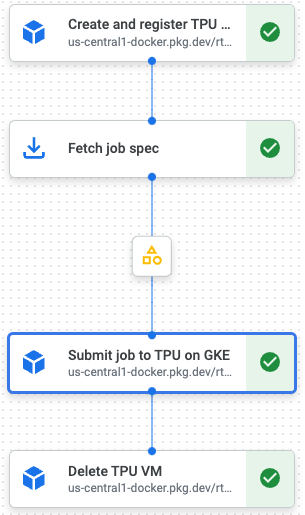

### Compile the pipeline
The pipeline must be compiled to run on Vertex AI Pipeline services. The compiled pipeline is in JSON format with all information and dependencies required to run the pipeline.

In [ ]:
from src.pipelines.run_job_tpu_vm_in_gke_pipeline import tpu_in_gke_pipeline as pipeline

compiler.Compiler().compile(
    pipeline_func=pipeline, 
    package_path=f'pipeline-tpu-in-gke.json')

### Configure runtime parameters

To run the pipeline, you must configure pipeline runtime parameters:

- `project`: Project ID of your environment
- `zone`: Google Cloud zone where your resources such as GKE cluster, TPU VM will be deployed and are located.
- `cluster`: GKE cluster name
- `gke_tpu_pool_name`: GKE node pool name where TPU VM will be registered
- `tpu_name`: Name of the TPU VM to create
- `tpu_type`: TPU configuration. E.g. `v2-8`, `v3-8`, `v2-32` etc.
- `tpu_runtime_version`: Version of TPU software
- `job_spec_path`:  Cloud Storage path to the training job specification file (YAML)

For convenience, most of these [parameters are set previously](#Configure-Environment-Settings) in the notebook.

In [ ]:
pipeline_params = {
    "project": PROJECT_ID,
    "zone": ZONE,
    "cluster": GKE_CLUSTER_NAME,
    "job_spec_path": GCS_JOB_SPEC_PATH,
    "gke_tpu_pool_name": GKE_TPU_POOL_NAME,
    "tpu_name": TPU_NAME,
    "tpu_type": TPU_TYPE,
    "tpu_runtime_version": TPU_RUNTIME_VERSION
}
pipeline_params

### Submit a pipeline run

The pipeline is submitted to Vertex AI Pipelines by defining a `PipelineJob` using Vertex AI SDK for Python client, passing the pipeline runtime paraeters.

In [ ]:
# initialize Vertex AI SDK
vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=f'gs://{BUCKET_NAME}/staging')

You will be able to monitor the run including the logs using the link printed by executing the cell.

In [ ]:
labels = {'experiment_id': EXPERIMENT_ID.lower(), 'tpu_type': TPU_TYPE.lower()}

# define pipeline job
pipeline_job = vertex_ai.PipelineJob(
    display_name=PIPELINE_NAME,
    job_id=f"{PIPELINE_NAME}-{get_timestamp()}",
    template_path=f'pipeline-tpu-in-gke.json',
    pipeline_root=f'gs://{BUCKET_NAME}/pipeline_runs/{PIPELINE_NAME}',
    parameter_values=pipeline_params,
    enable_caching=False,
    labels=labels
)

pipeline_job.run(sync=False)
pipeline_job.wait_for_resource_creation()

In [ ]:
# Check the state of the pipeline
pipeline_job.state

You can access the pipeline run metadata by pipeline name and load metadata into a Pandas DataFrame. 

In [ ]:
df_run_metadata = vertex_ai.get_pipeline_df(pipeline="pipeline-tpu-in-gke")
df_run_metadata

---